# Stationarity

In this section we will cover
- Definition of stationarity and examples of common stationary and nonstationary time series.
- How to detect stationarity.
- The most common ways to transform nonstationary time series into stationary ones.

In [61]:
import warnings
warnings.filterwarnings('ignore')
from io import BytesIO
import requests
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.fft import fft
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
np.random.seed(42) # Reproducibility

---

### Why do we care about stationarity?

- Stationarity is a key assumption to time series analysis.
- Without it many basic time series models would break.
- Transformations can be applied to convert a nonstationary time series to a stationary one.

### What is stationarity?

- Intuition: a time series is stationary when there are no changes in the underlying system that generates it.
- We define it to be:

    - Constant mean (no trend).
    - Constant variance (no heteroskedasticity).
    - Constant autocorrelation structure.
    - No periodic component.

- Let's create an utility function to make plots.

In [62]:
def run_sequence_plot(x, y, title, xlabel="Time", ylabel="Values", ax=None):
    if ax is None:
        _, ax = plt.subplots(1,1, figsize=(10, 3.5))
    ax.plot(x, y, 'k-')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(alpha=0.3)
    return ax

- First, we create a variable `time` that defines equally-spaced time intervals.
- Then we'll sample values from a Normal distribution with a mean of 0 and a standard deviation of 1.
- Essentially we're creating white noise, which is a stationary time series as it exhibits all the properties required of a stationary time series.

In [63]:
T = 200
time = np.arange(T)
stationary = np.random.normal(loc=0, scale=1.0, size=(T))

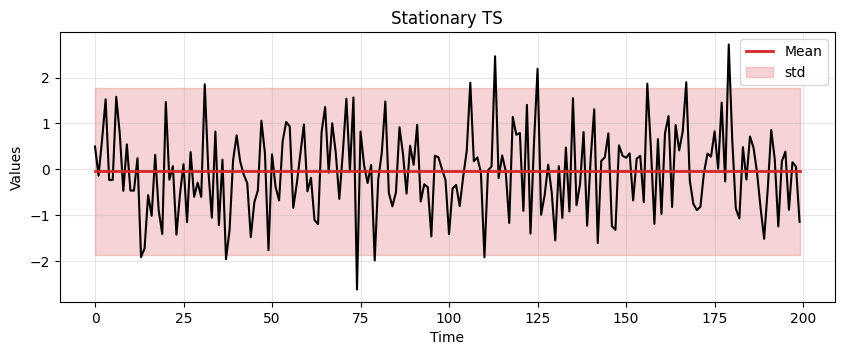

In [64]:
ax = run_sequence_plot(time, stationary, title="Stationary TS")
ax.plot(time, np.ones_like(time)*np.mean(stationary), linewidth=2, color='tab:red', label='Mean');
ax.fill_between(time, np.ones_like(time)*(stationary.mean()-1.96*stationary.std()), 
                np.ones_like(time)*(stationary.mean()+1.96*stationary.std()), 
                color='tab:red', alpha=0.2, label='std')
plt.legend();

- We can easily check that the white noise has constant mean, constant variance, and no periodicity.
- What about the autocorrelation?

#### Autocorrelation
- Autocorrelation measures how much the current time series measurement is correlated with a past measurement. 
- For example, today's temperature is often highly correlated with yesterday's temperature. 
- To discuss these things we must introduce the idea of a *lag*, i.e., a delay. 

![Autocorrelation](media/Autocorrelation.gif)

- Say you wanted to know if today's temperature correlates more with yesterday's temperature or the temperature from two days ago. 
- You could test this by computing the correlation between the original time series and the same series delayed 1 time step. 
- The second value of the original time series would be compared with the first of the delayed time series. 
- The third original value would be compared with the second of the delayed. 
- And so on. 

Autocorrelation often results in a pattern, whereas a time series without autocorrelation looks random.

**Example: constant autocorrelation**

- Time series of daily temperature in a specific location over a year. 
- If this location has a very stable climate, the day-to-day changes in temperature might be minimal and consistent throughout the year. 
- Then, the autocorrelation would be relatively constant. 
- E.g., the correlation between today's temperature and tomorrow's temperature is roughly the same as the correlation between the temperature 30 days ago and 29 days ago.

**Example: time-varying autocorrelation**

- Time series representing the daily stock prices of a particular company. 
- Stock prices can be influenced by market trends, company performance, economic indicators, world events, etc... 
- Here, the autocorrelation might be time-dependent. 
- E.g., during a period of market stability, the stock prices might show a consistent pattern over time (e.g., a steady increase). 
- However, during a market upheaval or a significant company event (like a product launch or a scandal), the pattern could change dramatically. 

### Common stationary and nonstationary time series

- If the analytic expression of the time series is known, it is possible to check the conditions for stationarity. 
- In practice, the process generating the time series might be unknown and we'll need other tools to check stationarity.
- Starting the analysis by looking at the `run_sequence_plot` is an excellent starting point. 

#### White noise

- We already looked at this time series and conclude that mean and variance are constant and there is no seasonal component.
- In addition, since the value of each time step is drawn independently, there is no correlation.

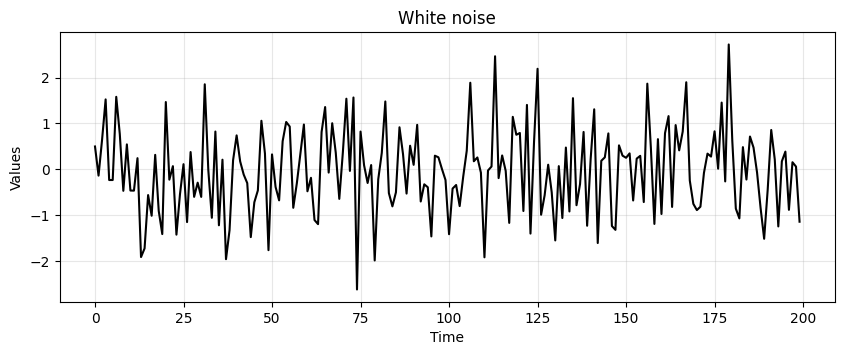

In [65]:
run_sequence_plot(time, stationary, title="White noise");

#### Random walk

- The random walk is one of the most important **nonstationary** time series.
- It is defined as:

$$X(t) = X(t-1) + \epsilon_t$$

- where $\epsilon_t$ are the steps and sampled randomly.
- Let's create a random walk.

In [66]:
seed = 4

rand_walk = np.empty_like(time, dtype='float')
for t in time:
    rand_walk[t] = seed + np.random.normal(loc=0, scale=2.5, size=1)[0]
    seed = rand_walk[t]

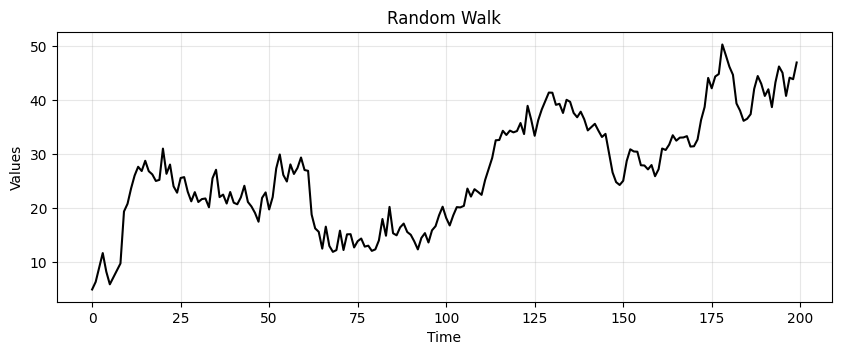

In [67]:
run_sequence_plot(time, rand_walk, title="Random Walk");

- Notice how the current value is highly correlated with the past values and fluctuates much less than the white noise.
- The random walk is nonstationary.

#### Time series with trend

- Consider the following data.

In [68]:
trend = (time * 2.75) + stationary

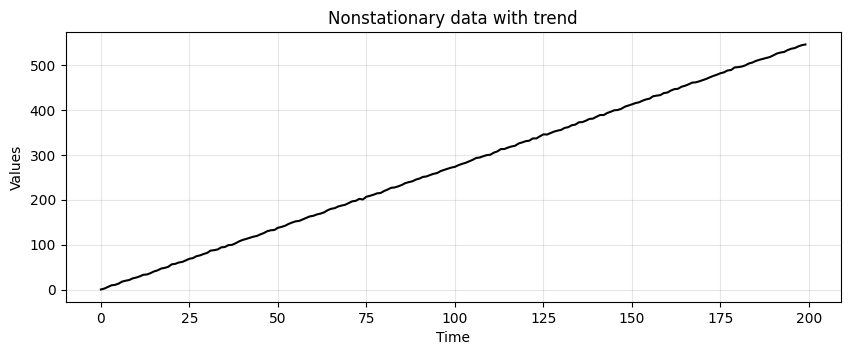

In [69]:
run_sequence_plot(time, trend, title="Nonstationary data with trend");

- Is this data stationary?

- No, the mean changes over time (i.e. there is a trend)

#### Time series with seasonality

In [70]:
seasonality = 10 + np.sin(2*np.pi*time/24)*10

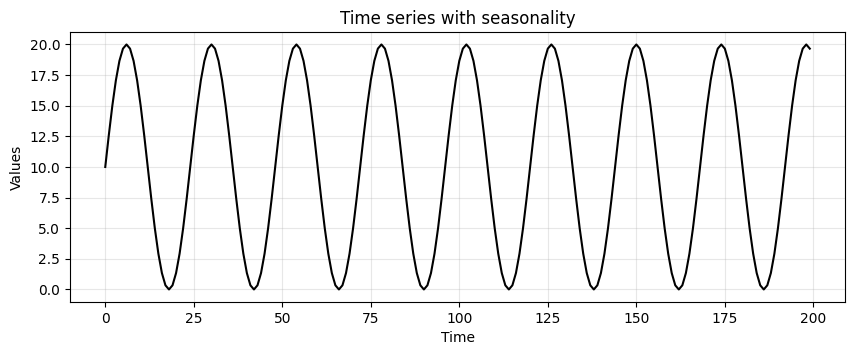

In [71]:
run_sequence_plot(time, seasonality, title="Time series with seasonality");

- Is this time series stationary?

- The mean of a periodic signal over a complete cycle always assumes the same value (`10` in our case).
- However, over an half-cycle or any period not equal to an integer multiple of the full cycle, the mean changes (is different from `10`). 
- This indicates that the mean is not constant over time

![Sin stationary](media/SinStationary.gif)

## Detecting stationarity

Next, we will talk about some techniques used to identify if a time series is stationary or not. 

Specifically, we will focus on the Augmented Dickey-Fuller Test.

### Augmented Dickey-Fuller Test

- This is a statistical procedure to determine whether a time series is stationary or not. 
- We will discuss more details about the test in the next lectures.
- For now, that's what we need to know:
    1. **Null hypothesis:** $H_0$: the series is nonstationary.
    2. **Alternative hypothesis:** $H_A$: the series is stationary.

- Like any statistical test you should set a significance level or threshold that determines whether you should accept or reject the null. 
- The values $\alpha=0.05$ or $\alpha=0.01$, which yield a confidence of $95\%$ and $99\%$, respectively, are common choices.

Example: $p = 0.0001 \rightarrow$ reject $H_0 \rightarrow$ the time series is stationary

Example: $p = 0.43 \rightarrow$ fail to reject $H_0 \rightarrow$ the time series is non-stationary

#### Stationary Data & ADF

- Let's see how to run this test in Python.

In [72]:
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(stationary)

- Let's see and comment the main outputs from the ADF test. 

In [73]:
print(f"ADF: {adf:.2f}")

ADF: -14.74


- First, `adf` is the value of the test statistic. 
- The more negative the value, the more confident we can be that the series is stationary. 
- Here we see a negative value. 
- That may not mean anything to you just yet but `pvalue` should.

In [74]:
print(f"p-value: {pvalue}")

p-value: 2.543125112212854e-27


- The `pvalue` is interpreted like any p-value. 
- The `pvalue` should be compared with the confidence levels (e.g., $\alpha=0.05$ or $\alpha=0.01$).
- Based on the comparison, we reject or fail to reject $H_0$. 
- Here ``pvalue`` is very close to zero so we **reject** the $H_0$ in favor of $H_A$ and conclude that the time series is stationary.

In [75]:
print(f"nobs: {nobs}")

nobs: 199


- The variable `nobs` is simply the number of observations in the time series.

In [76]:
print(f"critical values: {critical_values}")

critical values: {'1%': np.float64(-3.4636447617687436), '5%': np.float64(-2.8761761179270766), '10%': np.float64(-2.57457158581854)}


- Finally, ``critical_values`` are the test statistic thresholds for common significant levels. 
- Here we see a test statistic lower than -2.87 is sufficient to reject $H_0$ at a significance level of 5%.

- You may have noticed two outputs we didn't discuss. 
- See [statsmodels docs](http://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html) for a description of ``usedlag`` and ``icbest``.

#### ADF on time series with trend
- Next, we run the ADF test on the `trend` time series. 

In [77]:
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(trend, regression='c')
print(f"ADF: {adf:.2f}")
print(f"p-value: {pvalue:.3f}")
print(f"critical values: {critical_values}")

ADF: 0.10
p-value: 0.966
critical values: {'1%': np.float64(-3.4654311561944873), '5%': np.float64(-2.8769570530458792), '10%': np.float64(-2.574988319755886)}


- As expected, we fail to reject $H_0$ that the `trend` time series is nonstationary.

### ADF on random walk

- Finally, we run the ADF test on the `rand_walk` time series.

In [78]:
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(rand_walk, regression='c')
print(f"ADF: {adf:.2f}")
print(f"p-value: {pvalue:.3f}")
print(f"critical values: {critical_values}")

ADF: -1.82
p-value: 0.371
critical values: {'1%': np.float64(-3.4636447617687436), '5%': np.float64(-2.8761761179270766), '10%': np.float64(-2.57457158581854)}


- As we discussed before, the random walk is nonstationary because its variance $\sigma^2t$ is not constant over time.

---

## Common transformations to achieve stationarity

- There are several ways to transform nonstationary time series data:

Transformation | Effect
:---|:---
Subtract trend | Constant mean
Apply log | Constant variance
Differencing | Remove autocorrelation 
Seasonal differencing | Remove periodic component

- Sometimes you'll have to do multiple transformations on the same dataset.
- Note that this is just a small subset of the total possible ways to transform nonstationary time series. 
- We'll focus on subtracting the trend and seasonal differencing for now

### Subtract estimated trend & seasonality

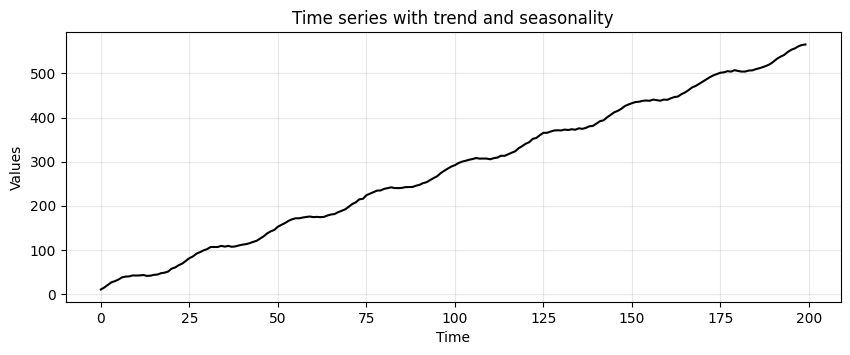

In [79]:
trend_seasonality = trend + seasonality
run_sequence_plot(time, trend_seasonality, title="Time series with trend and seasonality");

In [80]:
adf_b4, pvalue_b4, _, _, _, _ = adfuller(trend_seasonality)
print(f"ADF: {adf_b4:.2f}")
print(f"p-value: {pvalue_b4:.3f}")

ADF: -0.28
p-value: 0.929


- Nonstationary as expected. 
- Next, we apply the decomposition.

In [81]:
ss_decomposition = seasonal_decompose(x=trend_seasonality, model='additive', period=24)
est_trend = ss_decomposition.trend
est_seasonal = ss_decomposition.seasonal
est_noise = ss_decomposition.resid

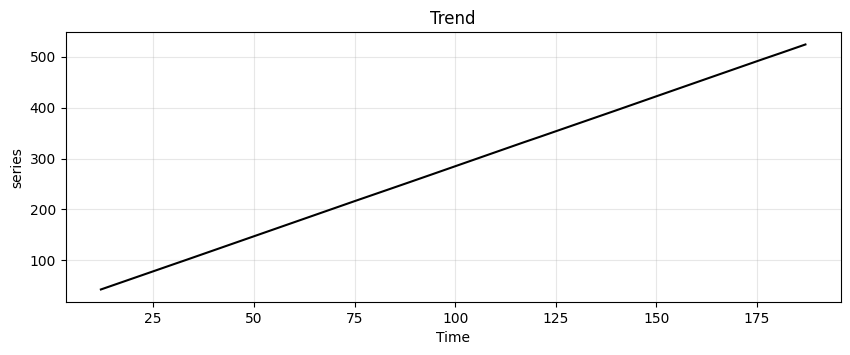

In [82]:
run_sequence_plot(time, est_trend, title="Trend", ylabel="series");

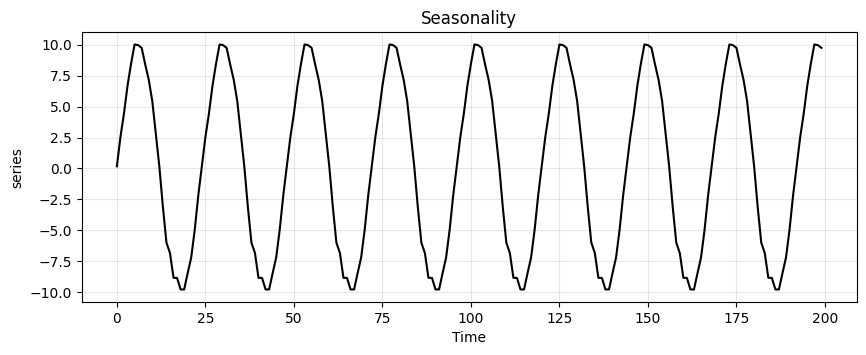

In [83]:
run_sequence_plot(time, est_seasonal, title="Seasonality", ylabel="series");

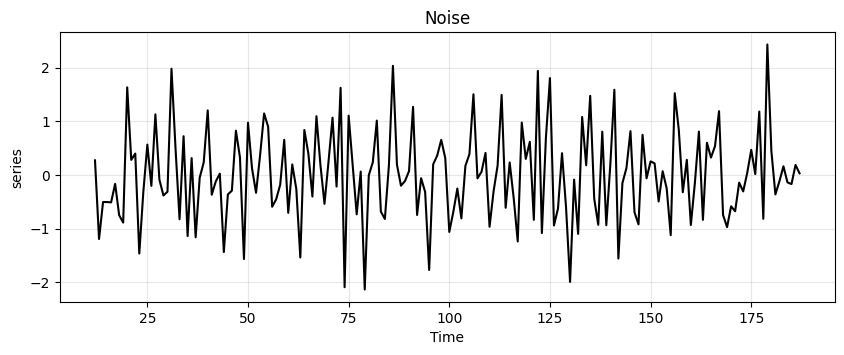

In [84]:
run_sequence_plot(time, est_noise, title="Noise", ylabel="series");

- Let's look at the residual values.

In [85]:
print(est_noise[:20])
print('...')
print(est_noise[-20:])

[        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
  0.27211609 -1.19594945 -0.50444018 -0.50638219 -0.51225125 -0.16578987
 -0.75150172 -0.88957711]
...
[ 0.44755405 -0.36391449 -0.11867315  0.16158118 -0.13943343 -0.1707093
  0.18690891  0.02980826         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan]


- We'll have to remove the first $12$ and last $12$ values to run an ADF test since those are `nan`. 
- The number 12 is due to the fact that the method applies seasonal differencing and we specified `period=24`.
- Here's how to do that and run the test all in one call.

In [86]:
adf_after, pvalue_after, _, _, _, _ = adfuller(est_noise[12:-12])
print(f"ADF: {adf_after:.2f}")
print(f"p-value: {pvalue_after:.3f}")

ADF: -6.19
p-value: 0.000


- Now the time series is stationary

### Seasonal differentiation

- Consider a time series with a seasonality of period $L$.
- There will be a strong correlation between $X(t)$ and $X(t+L)$.
- Seasonal differentiation can remove the seasonality and make the time series stationary:

$$\hat{X}(t) = X(t+L) - X(t)$$

- After seasonal differencing the time series will become $L$ steps shorter.
- Note that we can perform the standard differentiation in cascade to seasonal differentiation if we need to remove also the trend on top of the seasonality.
- Let's see this on the `trend_seasonality` time series.

![Seasonal Differencing](media/SeasonalDifferencing.gif)

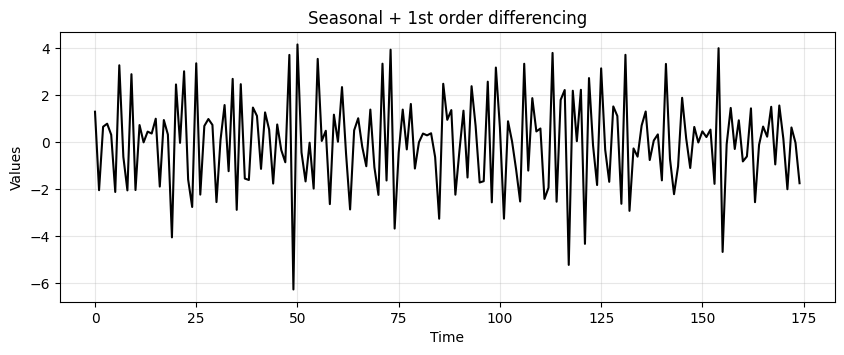

In [87]:
trend_seasonality_d24 = (trend_seasonality[:-24] 
                         - trend_seasonality[24:]) # remove seasonality
trend_seasonality_d24_d1 = (trend_seasonality_d24[:-1] 
                            - trend_seasonality_d24[1:]) # remove trend

# Plot the differenced time series
run_sequence_plot(time[:-25], trend_seasonality_d24_d1, title="Seasonal + 1st order differencing");

## Summary

In this lecture we learned: 
1. What does it mean for a time series to be stationary.
2. A set of notable stationary and nonstationary time series.
2. Common tools to identify stationarity.
3. Useful nonstationary-to-stationary transformations.

---

### Exercises

In [88]:
star = [16107.689,16104.023,16105.128,16095.002,16096.814,16096.265,16091.785,16092.7295,16080.386,16090.493,16084.883,16090.18,16096.468,16100.509,16091.935,16089.44,16087.315,16092.364,16094.239,16111.95,16104.438,16106.257,16098.142,16091.222,16087.192,16084.163,16077.915,16075.96,16070.055,16081.284,16069.485,16078.265,16076.675,16075.807,16082.967,16085.851,16076.889,16080.938,16070.631,16082.345,16067.991,16090.196,16081.907,16068.685,16071.576,16073.469,16071.027,16063.492,16075.434,16077.611,16072.301,16075.506,16073.163,16075.154,16083.05,16073.6045,16073.835,16059.113,16087.578,16067.476,16060.08,16066.245,16066.321,16061.156,16058.928,16066.254,16061.206,16047.011,16064.528,16064.684,16058.119,16052.295,16087.351,16058.05,16061.868,16059.249,16062.923,16075.118,16061.6455,16055.977,16068.33,16060.174,16058.826,16049.44,16052.404,16061.54,16052.887,16049.072,16060.12,16052.22,16061.971,16063.89,16062.469,16051.674,16062.12,16041.304,16047.114,16051.104,16046.433,16048.281,16049.489,16049.833,16056.934,16052.995,16049.144,16051.087,16038.143,16059.505,16058.241,16045.599,16046.485,16047.448,16063.831,16037.514,16060.764,16051.779,16058.21,16053.718,16050.795,16050.508,16060.436,16045.347,16054.657,16059.114,16052.682,16050.931,16053.775,16058.067,16048.921,16054.297,16058.405,16057.17,16065.001,16060.428,16063.963,16056.705,16051.088,16055.949,16057.565,16046.149,16067.182,16055.588,16066.489,16058.429,16067.467,16068.018,16062.525,16062.408,16063.656,16062.109,16069.546,16067.963,16061.181,16095.249,16064.056,16073.632,16067.164,16061.71,16062.44,16078.128,16085.34,16062.214,16081.196,16070.617,16082.377,16077.445,16076.261,16081.954,16073.798,16063.869,16068.787,16066.25,16081.239,16079.187,16089.0,16074.726,16079.574,16076.485,16093.785,16082.778,16093.334,16081.17,16095.84,16099.521,16090.341,16096.32,16088.468,16095.236,16090.908,16094.96,16098.663,16087.415,16094.252,16093.507,16098.56,16096.312,16091.927,16091.94,16099.119,16094.219,16093.86,16094.812,16096.5,16096.821,16098.961,16104.906,16097.96,16115.015,16114.426,16108.223,16114.266,16107.376,16110.915,16106.662,16109.624,16104.429,16118.004,16116.62,16115.102,16122.273,16111.022,16116.68,16111.832,16116.424,16115.748,16114.431,16122.735,16128.237,16128.55,16126.283,16125.863,16111.855,16109.87,16120.602,16135.814,16154.027,16130.838,16130.5625,16111.979,16132.095,16134.631,16117.573,16129.17,16139.738,16132.279,16123.105,16125.933,16120.645,16132.114,16114.185,16134.739,16129.796,16129.19,16125.495,16132.082,16146.465,16142.206,16131.684,16134.067,16139.33,16130.297,16134.498,16138.291,16142.586,16128.109,16144.84,16138.881,16126.134,16137.538,16141.939,16142.306,16140.845,16140.992,16135.473,16134.347,16130.529,16138.213,16146.671,16146.014,16144.294,16144.629,16140.016,16147.886,16144.469,16139.28,16149.265,16142.334,16143.87,16147.282,16146.695,16142.118,16145.194,16155.879,16152.033,16153.573,16152.382,16148.753,16149.832,16143.1875,16149.067,16160.827,16143.998,16156.517,16165.592,16157.375,16163.559,16167.351,16160.704,16148.828,16157.396,16152.499,16163.9795,16156.13,16150.978,16155.604,16153.011,16145.678,16157.064,16151.505,16156.14,16165.744,16166.518,16157.455,16147.471,16148.558,16165.178,16155.15,16170.812,16165.675,16163.739,16169.498,16164.939,16173.422,16173.96,16170.474,16160.648,16170.943,16172.483,16168.761,16168.043,16156.462,16166.776,16156.821,16162.971,16158.5205,16169.721,16159.29,16154.469,16178.368,16175.262,16168.389,16171.521,16156.087,16179.904,16168.024,16168.556,16154.7,16153.119,16170.797,16170.12,16157.927,16168.1875,16168.633,16168.735,16165.196,16181.568,16152.164,16170.346,16150.442,16166.23,16165.495,16169.108,16154.161,16155.601,16160.649,16164.563,16167.345,16162.46,16165.532,16151.798,16162.191,16171.51,16157.17,16159.228,16147.177,16165.409,16157.199,16153.508,16158.895,16155.489,16153.8,16151.725,16142.56,16140.022,16142.931,16152.655,16149.254,16144.577,16146.504,16194.995,16153.782,16153.152,16157.114,16150.729,16156.067,16144.123,16148.303,16145.595,16136.688,16143.463,16139.213,16146.695,16126.24,16126.683,16139.085,16139.088,16131.16,16132.631,16139.8545,16128.523,16122.643,16131.441,16128.1455,16119.221,16116.282,16110.055,16125.732,16124.194,16125.917,16113.967,16114.538,16110.767,16103.792,16110.428,16120.95,16111.469,16110.505,16114.363,16115.212,16100.07,16114.43,16109.608,16102.075,16103.324,16105.866,16103.07,16108.279,16091.996,16094.785,16089.797,16100.125,16090.365,16097.708,16108.12,16099.941,16100.973,16091.097,16081.398,16083.742,16082.48,16094.99,16091.901,16087.184,16088.982,16086.7295,16075.83,16077.706,16085.483,16071.841,16060.514,16079.877,16079.926,16083.732,16075.387,16074.963,16060.41,16070.963,16067.105,16061.906,16064.829,16073.214,16072.324,16054.548,16050.927,16054.191,16059.194,16050.119,16057.234,16051.12,16061.252,16066.471,16055.678,16059.365,16052.768,16050.795,16065.743,16057.784,16046.167,16052.923,16064.969,16047.713,16051.747,16053.273,16049.567,16051.473,16061.84,16056.77,16055.56,16048.313,16042.333,16040.275,16043.828,16052.508,16047.933,16040.97,16051.88,16042.695,16035.277,16053.34,16048.085,16047.52,16041.519,16046.84,16052.205,16051.1455,16029.961,16043.832,16045.392,16034.205,16036.768,16042.747,16042.408,16047.287,16033.183,16042.854,16032.293,16045.803,16040.406,16040.17,16028.72,16035.34,16036.696,16049.604,16043.113,16038.288,16029.161,16049.37,16048.115,16028.657,16048.411,16045.704,16045.149,16037.963,16040.686,16049.436,16042.528,16041.64,16033.406,16054.67,16049.185,16046.61,16042.609,16043.418,16047.412,16045.075,16047.157,16046.326,16047.277,16037.8955,16048.267,16048.234,16058.9795,16058.93,16082.7295,16041.261,16060.911,16063.241,16063.325,16058.088,16073.422,16065.521,16052.764,16051.017,16065.326,16057.792,16065.295,16066.444,16055.749,16064.992,16061.045,16060.92,16065.459,16059.523,16078.311,16065.811,16065.581,16075.283,16058.723,16059.378,16067.249,16090.9375,16069.868,16081.168,16080.293,16073.982,16065.257,16068.903,16061.929,16073.471,16059.1875,16069.895,16076.8955,16077.271,16073.016,16086.952,16072.49,16076.957,16071.564,16074.884,16083.414,16075.253,16085.334,16076.267,16094.444,16081.336,16075.469,16079.868,16084.555,16083.496,16078.632,16087.368,16095.844,16076.844,16081.883,16098.7295,16089.777,16087.644,16098.129,16086.301,16101.327,16084.114,16103.468,16096.346,16090.805,16106.364,16101.081,16091.326,16089.143,16101.364,16086.455,16089.53,16108.867,16110.969,16125.782,16098.645,16109.315,16107.181,16114.061,16098.22,16118.341,16103.326,16101.495,16097.12,16095.989,16096.72,16093.944,16103.856,16105.5625,16103.023,16107.858,16110.446,16105.091,16102.373,16102.559,16116.409,16093.138,16122.704,16119.599,16118.305,16114.28,16118.236,16124.975,16114.977,16115.698,16124.043,16125.502,16126.7,16101.763,16137.751,16133.961,16126.515,16123.72,16126.499,16123.3,16120.092,16139.101,16122.153,16127.468,16128.731,16122.798,16127.647,16121.308,16131.681,16131.247,16137.184,16134.244,16152.601,16144.556,16154.683,16131.193,16142.194,16149.722,16147.175,16143.869,16151.242,16148.169,16135.499,16143.191,16146.31,16142.571,16151.287,16138.487,16152.921,16158.884,16147.049,16158.341,16153.523,16154.479,16150.323,16152.839,16154.844,16153.483,16158.315,16166.241,16154.426,16148.091,16157.721,16153.717,16152.082,16149.509,16144.096,16146.929,16150.941,16159.242,16157.048,16165.157,16172.596,16159.528,16156.381,16156.079,16156.972,16149.173,16163.251,16144.966,16140.599,16150.133,16168.008,16164.884,16161.576,16157.846,16188.211,16172.316,16167.767,16164.12,16169.909,16172.393,16170.852,16168.528,16180.083,16200.926,16193.168,16175.889,16163.282,16153.674,16157.223,16170.138,16167.069,16176.727,16161.776,16165.781,16173.104,16168.982,16157.264,16170.03,16176.944,16163.546,16170.961,16169.22,16175.506,16176.131,16174.212,16174.335,16166.042,16169.892,16155.511,16171.796,16164.049,16171.904,16162.751,16167.276,16174.821,16172.64,16173.979,16181.757,16168.372,16168.853,16167.442,16176.714,16183.134,16174.438,16172.478,16170.77,16168.28,16172.043,16172.858,16174.044,16165.225,16169.919,16176.108,16152.534,16153.393,16152.193,16158.813,16150.857,16158.506,16165.8955,16170.442,16160.495,16157.385,16151.725,16150.563,16147.034,16166.305,16163.195,16147.939,16150.173,16154.19,16136.282,16154.236,16139.733,16145.927,16143.234,16144.012,16123.229,16149.34,16131.424,16136.079,16132.03,16141.991,16131.153,16132.357,16125.381,16134.532,16133.687,16136.45,16121.226,16126.868,16116.699,16116.608,16147.904,16120.499,16122.899,16124.984,16133.422,16143.42,16113.8955,16122.706,16113.484,16110.1045,16110.986,16101.267,16102.67,16115.938,16112.868,16112.951,16100.495,16103.702,16094.415,16112.794,16103.026,16097.409,16102.562,16100.5625,16094.353,16081.379,16100.069,16083.493,16082.584,16086.493,16084.3125,16080.866,16094.094,16085.534,16084.5625,16078.272,16072.695,16071.137,16062.209,16076.502,16072.299,16064.091,16074.108,16064.366,16101.403,16068.342,16070.588,16060.396,16074.469,16069.154,16060.2295,16055.519,16057.056,16057.172,16061.933,16054.121,16054.6455,16054.382,16042.599,16048.215,16046.023,16049.082,16044.929,16060.32,16047.407,16050.32,16052.939,16054.939,16062.378,16052.502,16049.057,16056.267,16042.659,16036.808,16041.434,16048.359,16043.076,16031.626,16029.899,16025.877,16042.926,16046.911,16035.007,16030.269,16037.445,16029.728,16046.303,16023.123,16033.452,16034.401,16033.512,16024.447,16038.106,16028.995,16031.11,16030.344,16034.929,16023.363,16025.806,16022.95,16019.065,16028.802,16020.045,16030.728,16037.099,16035.319,16028.531,16018.895,16024.395,16018.2295,16005.728,16017.973,16012.413,16014.794,16020.393,16012.593,16027.429,16029.023,16049.542,16034.019,16024.715,16026.15,16013.405,16010.411,16013.899,16023.436,16042.686,16023.543,16021.233,16034.934,16019.5625,16028.549,16005.998,16032.741,16009.938,16017.6,16017.72,16022.087,16023.627,16011.482,16032.368,16024.472,16019.235,16034.65,16021.879,16018.117,16034.565,16028.753,16028.93,16031.39,16039.165,16029.201,16025.238,16028.176,16017.128,16014.207,16032.237,16022.002,16012.211,16027.412,16020.325,16027.216,16033.409,16031.599,16034.988,16025.704,16022.196,16042.6045,16027.399,16025.908,16033.837,16030.826,16027.996,16024.676,16028.5205,16030.835,16043.496,16033.718,16034.187,16027.838,16041.944,16042.742,16034.368,16025.847,16027.626,16030.958,16033.126,16043.267,16045.575,16048.926,16047.562,16055.082,16041.239,16040.814,16034.29,16035.042,16037.615,16025.267,16039.541,16043.205,16046.449,16043.466,16052.303,16037.956,16049.388,16054.548,16049.067,16063.707,16045.174,16058.068,16043.071,16046.137,16041.393,16054.783,16035.926,16049.431,16041.381,16035.555,16045.278,16043.597,16060.941,16055.412,16051.489,16056.236,16047.813,16047.716,16045.429,16055.64,16047.8125,16049.563,16050.162,16053.9795,16056.406,16040.256,16056.198,16059.118,16047.391,16048.975,16052.384,16050.231,16073.836,16051.991,16056.474,16055.852,16062.251,16051.106,16055.919,16061.505,16063.684,16067.271,16055.947,16064.01,16056.295,16067.545,16062.597,16066.391,16055.836,16064.844,16062.866,16057.345,16048.534,16065.281,16057.57,16063.296,16073.172,16062.689,16070.502,16064.685,16067.562,16068.591,16059.033,16067.99,16072.191,16076.56,16081.396,16073.625,16066.902,16073.563,16073.786,16098.478,16086.009,16085.272,16080.786,16088.561,16083.653,16086.267,16081.329,16088.07,16092.693,16086.163,16090.563,16093.949,16095.663,16095.323,16111.623,16095.213,16093.671,16105.536,16094.598,16088.977,16098.516,16097.13,16102.028,16106.965,16107.238,16102.502,16117.127,16096.28,16114.437,16109.8545,16115.221,16118.108,16103.811,16113.37,16116.921,16110.608,16118.931,16109.584,16109.11,16126.873,16113.55,16113.933,16113.748,16119.367,16127.62,16127.988,16118.684,16129.95,16137.797,16129.815,16133.083,16133.394,16136.619,16139.694,16130.984,16136.573,16151.767,16140.78,16142.487,16150.162,16136.034,16140.86,16149.536,16160.782,16146.34,16150.654,16164.066,16164.046,16165.031,16162.274,16157.336,16162.53,16160.364,16165.049,16159.92,16162.721,16159.195,16169.799,16164.774,16176.895,16174.063,16185.207,16172.834,16177.576,16168.772,16171.282,16168.588,16169.7295,16164.6455,16177.72,16171.324,16188.723,16190.965,16180.681,16183.383,16181.172,16175.248,16188.806,16182.222,16189.926,16176.316,16180.6045,16182.127,16179.667,16183.2,16178.469,16181.135,16182.978,16187.833,16182.021,16180.191,16176.904,16197.8,16178.789,16176.833,16183.271,16187.111,16188.98,16184.305,16189.275,16186.296,16192.078,16171.093,16182.324,16176.303,16175.413,16174.889,16173.584,16181.638,16178.827,16182.625,16181.348,16184.891,16190.39,16179.292,16183.789,16184.587,16182.738,16188.341,16184.016,16184.209,16185.816,16182.349,16186.607,16182.602,16171.863,16172.442,16175.876,16173.135,16192.085,16179.412,16188.733,16192.325,16174.817,16173.825,16163.664,16159.097,16177.333,16166.046,16167.057,16167.852,16160.254,16157.142,16159.5205,16159.888,16167.21,16168.152,16159.967,16159.712,16166.937,16162.81,16161.056,16162.465,16158.987,16168.294,16156.757,16148.819,16148.79,16166.281,16156.962,16140.855,16145.914,16140.326,16140.983,16140.684,16129.1,16130.923,16136.824,16131.732,16142.798,16139.752,16130.443,16130.078,16130.168,16120.742,16128.938,16125.555,16130.104,16136.424,16129.662,16119.297,16125.583,16117.014,16124.819,16115.918,16114.875,16107.285,16113.948,16108.847,16103.872,16098.942,16107.936,16106.769,16104.542,16099.631,16114.169,16103.089,16109.671,16092.768,16113.4795,16094.589,16091.244,16091.681,16094.652,16105.591,16092.46,16097.3,16092.925,16087.469,16088.041,16086.465,16089.403,16091.742,16079.874,16084.862,16086.007,16085.657,16083.418,16072.547,16075.725,16070.368,16075.447,16064.691,16067.978,16076.124,16087.057,16083.629,16078.339,16084.812,16078.421,16078.3125,16068.043,16065.513,16075.496,16072.724,16069.44,16077.855,16078.973,16078.35,16078.102,16066.256,16070.164,16070.322,16080.55,16076.502,16074.94,16074.711,16061.62,16077.125,16055.999,16063.787,16075.8125,16058.949,16065.979,16064.135,16065.142,16074.001,16070.963,16080.37,16071.0,16069.757,16062.53,16069.081,16066.889,16073.784,16081.874,16076.862,16076.011,16097.344,16072.264,16069.572,16095.9,16067.106,16066.113,16065.361,16069.08,16072.148,16074.977,16073.325,16074.587,16072.243,16068.739,16073.631,16072.066,16070.863,16069.757,16069.68,16076.332,16066.572,16073.52,16074.856,16063.61,16069.622,16073.981,16091.096,16068.603,16059.025,16075.761,16069.264,16049.048,16051.644,16047.739,16047.38,16039.932,16041.185,16038.081,16050.016,16044.455,16051.073,16040.55,16045.239,16033.703,16030.311,16030.835,16044.588,16030.427,16041.278,16038.181,16045.466,16050.56,16048.731,16046.105,16045.432,16030.745,16039.512,16039.226,16037.575,16045.964,16044.811,16040.157,16027.403,16046.002,16046.512,16040.0625,16042.375,16046.092,16041.176,16042.31,16038.875,16034.386,16048.523,16045.981,16036.473,16021.395,16039.543,16032.434,16035.487,16033.988,16036.301,16029.047,16032.036,16036.451,16042.945,16049.129,16052.254,16053.013,16046.6875,16036.067,16042.578,16048.832,16035.545,16051.39,16045.163,16050.077,16049.205,16051.39,16045.366,16044.438,16048.908,16050.069,16044.249,16054.518,16056.752,16044.95,16056.24,16055.262,16051.349,16050.682,16058.248,16050.821,16062.181,16058.744,16065.01,16054.809,16053.323,16054.062,16041.396,16049.143,16055.466,16055.352,16068.36,16060.693,16072.821,16064.646,16056.716,16071.728,16075.523,16058.359,16066.296,16071.238,16076.281,16068.582,16068.697,16070.6875,16076.751,16076.051,16084.4,16085.829,16085.291,16080.527,16078.31,16078.668,16072.58,16102.3955,16078.522,16086.492,16094.872,16079.441,16080.87,16085.873,16085.65,16099.112,16090.886,16093.57,16091.5625,16086.327,16080.191,16074.388,16084.547,16084.729,16098.85,16098.958,16099.254,16094.674,16109.543,16101.729,16104.957,16100.628,16104.361,16103.519,16105.801,16101.416,16099.893,16118.548,16108.013,16122.414,16127.684,16115.759,16121.497,16111.202,16121.287,16121.785,16119.659,16127.693,16133.888,16127.821,16123.919,16131.843,16135.976,16122.781,16125.917,16125.978,16138.705,16135.558,16130.788,16145.506,16133.941,16129.8,16136.014,16134.763,16138.016,16145.282,16141.005,16142.919,16140.499,16153.674,16157.552,16158.963,16149.868,16146.523,16142.502,16149.948,16149.654,16158.036,16142.779,16160.233,16156.043,16151.162,16152.054,16162.351,16162.235,16153.899,16161.727,16155.93,16153.892,16161.757,16164.014,16153.201,16161.177,16166.636,16163.823,16149.793,16153.58,16153.333,16170.59,16152.017,16152.184,16160.782,16162.771,16168.682,16161.1045,16158.65,16149.059,16165.569,16163.713,16156.128,16163.754,16155.984,16154.716,16154.427,16153.887,16147.813,16149.982,16146.845,16156.513,16142.534,16141.7,16141.373,16133.056,16154.103,16148.67,16148.97,16155.012,16129.99,16156.431,16150.03,16145.188,16133.089,16148.637,16151.26,16147.547,16141.863,16141.36,16154.496,16131.537,16153.99,16125.909,16129.594,16135.773,16146.955,16143.312,16142.539,16130.217,16129.758,16132.247,16114.441,16126.737,16130.619,16133.706,16135.559,16135.6455,16138.702,16127.324,16129.561,16134.85,16144.56,16140.777,16139.237,16147.182,16148.661,16141.692,16136.813,16141.753,16135.783,16127.348,16134.292,16129.135,16128.619,16127.457,16119.335,16142.666,16130.001,16125.716,16129.461,16143.588,16136.656,16136.505,16123.295,16126.11,16137.601,16132.635,16122.745,16121.978,16131.93,16142.554,16145.593,16127.035,16132.222,16132.037,16123.861,16119.247,16112.647,16135.889,16130.993,16135.243,16115.975,16125.86,16120.379,16133.879,16124.738,16132.374,16112.68,16117.27,16110.507,16111.127,16118.033,16122.739,16121.826,16113.518,16109.033,16113.919,16114.479,16109.847,16111.194,16115.741,16116.92,16116.821,16125.1455,16126.274,16113.239,16114.526,16121.287,16105.961,16118.08,16109.268,16115.522,16101.472,16113.344,16110.096,16109.998,16122.209,16120.208,16116.658,16116.942,16111.436,16107.583,16112.646,16099.652,16099.463,16111.233,16107.512,16102.844,16118.535,16104.888,16090.683,16094.643,16110.126,16097.0205,16112.115,16103.04,16107.073,16102.149,16101.361,16097.001,16112.561,16098.773,16101.632,16110.329,16098.291,16097.252,16104.574,16093.02,16104.249,16105.287,16109.356,16099.872,16106.361,16109.998,16094.4795,16095.771,16101.608,16092.786,16100.679,16085.929,16101.153,16101.947,16096.45,16091.652,16101.923,16090.326,16098.49,16102.022,16094.136,16090.005,16096.277,16100.236,16104.625,16099.231,16095.886,16090.266,16076.338,16080.758,16083.827,16083.075,16085.815,16064.058,16073.961,16081.022,16070.902,16067.313,16069.253,16063.589,16072.655,16083.588,16078.993,16074.208,16068.365,16053.539,16059.508,16059.432,16067.796,16057.376,16055.355,16059.726,16050.189,16055.399,16061.858,16048.707,16049.649,16047.279,16060.97,16054.007,16065.082,16056.075,16053.826,16065.176,16046.526,16040.108,16046.8,16031.469,16042.723,16057.618,16047.647,16050.548,16039.16,16031.188,16027.504,16022.281,16030.041,16015.788,16021.296,16030.945,16025.4795,16026.023,16024.424,16026.137,16008.318,16016.941,16018.269,16009.163,16002.666,16002.574,16002.714,16004.733,16010.531,16003.331,16003.196,16026.066,16000.438,16009.102,15997.4375,15994.62,15984.493,15983.057,15974.587,15978.184,15989.3545,15987.339,15985.416,15998.495,15989.036,15981.997,15977.713,15979.231,15980.894,15989.542,15973.36,15979.076,15986.753,16004.354,15982.925,15971.684,15971.92,15966.966,15962.626,15982.453,15968.287,15979.554,15970.671,15975.481,15980.973,15976.132,15967.691,15974.25,15982.742,15964.085,15962.984,15968.61,15977.258,15964.645,15976.7295,15977.807,15971.833,15977.7705,15990.13,15985.31,15972.112,15991.872,15977.153,15983.454,15980.156,15986.949,15967.346,15965.642,15978.722,15982.285,15988.058,15992.444,15976.792,15988.283,15985.4795,15992.41,16000.769,15992.504,15991.988,15989.09,15988.305,15998.372,16000.196,16000.99,16000.303,16002.737,16008.315,16005.142,15997.328,16005.738,16011.277,16012.214,16008.374,16021.131,16017.15,16012.308,16021.248,16026.44,16022.605,16021.361,16033.098,16024.693,16027.891,16025.454,16033.031,16019.193,16034.012,16049.982,16038.814,16039.868,16044.883,16048.759,16049.395,16059.445,16041.378,16039.862,16052.829,16054.17,16057.131,16064.494,16060.293,16067.183,16074.678,16071.801,16075.66,16087.196,16070.046,16073.04,16080.52,16074.243,16070.546,16083.437,16083.067,16085.521,16080.04,16097.88,16084.911,16081.524,16092.043,16098.99,16095.118,16097.719,16091.778,16091.986,16101.27,16103.731,16101.604,16115.374,16107.277,16117.588,16119.115,16116.166,16121.174,16129.591,16122.086,16111.303,16111.423,16126.658,16137.248,16121.489,16129.097,16133.438,16121.42,16126.089,16129.761,16121.833,16138.3545,16123.337,16135.29,16133.53,16147.115,16143.48,16136.635,16140.654,16147.413,16143.396,16129.338,16133.269,16134.665,16131.102,16132.057,16133.486,16132.215,16143.607,16159.901,16136.984,16146.874,16148.109,16140.108,16140.801,16154.146,16142.048,16146.953,16152.661,16156.941,16152.785,16152.607,16137.169,16139.8,16147.031,16146.91,16157.585,16155.172,16147.151,16143.588,16154.931,16146.107,16138.896,16142.228,16155.446,16150.344,16161.491,16155.424,16157.761,16161.452,16154.498,16158.095,16153.454,16150.622,16169.09,16155.29,16156.942,16153.211,16152.238,16158.111,16160.127,16157.472,16161.539,16166.576,16161.797,16172.775,16157.217,16153.058,16159.264,16149.283,16156.172,16152.196,16159.6,16162.249,16173.647,16164.541,16167.809,16181.607,16187.442,16172.489,16167.135,16173.122,16164.268,16172.645,16175.912,16167.75,16172.617,16175.369,16172.365,16185.336,16161.235,16171.504,16175.059,16172.309,16159.497,16174.974,16180.109,16175.184,16175.999,16167.22,16171.278,16183.688,16181.7705,16174.101,16162.635,16166.623,16165.561,16166.181,16170.781,16159.606,16159.005,16160.16,16168.9,16168.079,16164.321,16163.791,16166.403,16179.041,16183.242,16171.186,16173.84,16167.137,16154.498,16168.864,16164.238,16175.596,16166.876,16173.426,16172.152,16168.512,16173.788,16167.056,16183.826,16168.65,16174.262,16165.369,16174.99,16172.748,16175.958,16177.23,16172.65,16179.36,16183.85,16186.446,16185.37,16179.045,16188.099,16175.182,16174.824,16172.422,16178.198,16178.962,16193.348,16188.789,16201.872,16191.774,16179.155,16183.691,16180.435,16189.588,16178.061,16184.717,16175.766,16192.792,16195.263,16191.231,16180.617,16179.909,16181.778,16178.015,16175.02,16177.357,16173.608,16186.903,16171.971,16191.554,16174.873,16182.264,16194.06,16182.301,16195.453,16178.006,16176.226,16177.825,16170.571,16167.497,16179.442,16176.133,16172.834,16178.583,16180.263,16186.33,16159.354,16164.416,16170.686,16167.469,16159.301,16167.612,16158.901,16158.716,16159.272,16158.321,16149.676,16156.377,16155.548,16155.352,16166.011,16151.221,16154.63,16160.056,16157.297,16138.711,16134.212,16138.596,16132.593,16139.549,16143.957,16148.871,16138.44,16138.108,16132.867,16123.193,16125.49,16137.159,16123.408,16129.872,16122.372,16123.556,16123.129,16112.846,16121.579,16124.426,16124.679,16118.051,16119.632,16126.904,16108.806,16107.812,16094.637,16090.643,16082.649,16087.847,16079.841,16090.116,16088.225,16082.92,16098.014,16089.492,16077.946,16064.918,16075.973,16071.813,16070.55,16069.697,16065.401,16072.951,16069.825,16052.494,16062.274,16068.723,16055.834,16049.677,16069.597,16059.437,16061.969,16050.541,16059.689,16051.534,16039.377,16039.841,16034.861,16066.542,16039.235,16029.415,16038.129,16038.46,16023.501,16019.392,16039.533,16029.1045,16021.604,16018.763,15998.676,16012.692,16020.238,16008.87,16018.598,16007.521,16005.175,16011.184,16004.912,16015.392,16008.959,16004.72,16015.497,16009.149,16005.217,15993.629,16008.402,15999.678,16002.543,16008.033,15986.239,15987.567,15981.821,15986.316,15988.922,15994.195,15980.345,15980.894,15981.859,15978.332,15990.32,15985.239,15975.653,15971.055,15969.768,15977.093,15964.508,15974.778,15968.899,15977.64,15968.687,15974.357,15982.951,15983.746,15972.239,15974.67,15972.135,15983.027,15965.448,15958.764,15970.049,15975.683,15965.173,15967.018,15978.352,15973.169,15958.81,15958.649,15963.106,15960.565,15968.248,15958.767,15950.33,15949.469,15966.802,15957.226,15971.371,15968.192,15952.385,15955.908,15958.713,15968.188,15959.104,15954.146,15958.937,15967.493,15965.274,15970.556,15965.563,15972.895,15964.374,15968.374,15962.622,15975.609,15966.327,15962.736,15966.149,15980.075,15972.915,15971.412,15978.029,15984.181,15986.37,15985.185,15986.973,16000.627,15992.836,15988.319,15991.91,16000.426,15993.643,16001.481,16007.511,15996.954,16006.555,16001.426,16013.719,15995.354,15999.131,16001.904,15999.541,15988.346,16030.538,16016.114,16016.087,16025.213,16033.894,16017.565,16008.34,16010.235,16018.646,16018.68,16014.854,16031.945,16031.413,16034.473,16035.08,16034.85,16033.791,16041.109,16040.551,16045.15,16030.904,16040.404,16036.466,16043.883,16041.465,16047.467,16046.937,16046.529,16051.94,16050.378,16055.848,16064.342,16064.357,16056.126,16067.117,16067.595,16069.895,16062.278,16067.768,16065.716,16061.313,16069.326,16084.896,16081.131,16070.226,16068.255,16071.543,16063.852,16073.905,16076.174,16082.385,16083.43,16094.192,16088.524,16082.569,16077.346,16082.266,16098.001,16084.663,16087.852,16096.316,16090.543,16088.045,16094.745,16097.142,16094.296,16096.786,16113.043,16117.472,16098.842,16104.582,16111.265,16092.324,16103.276,16105.156,16114.417,16109.721,16114.981,16112.111,16119.746,16125.49,16121.596,16130.647,16129.995,16123.283,16120.03,16127.814,16136.952,16127.517,16128.73,16133.675,16129.75,16121.158,16131.372,16133.384,16129.096,16150.034,16155.9,16131.435,16148.289,16141.393,16140.339,16139.959,16154.658,16159.541,16149.12,16153.239,16163.709,16152.004,16150.49,16157.7705,16143.598,16155.877,16143.115,16154.619,16160.475,16158.987,16164.795,16178.847,16171.994,16176.037,16175.124,16166.938,16165.105,16156.093,16172.967,16163.947,16170.671,16173.207,16176.301,16179.079,16162.437,16171.604,16169.2705,16167.109,16172.975,16165.32,16173.566,16177.595,16183.995,16177.15,16186.177,16185.69,16177.948,16186.635,16190.675,16169.8125,16189.163,16202.328,16184.185,16193.893,16192.561,16194.63,16191.919,16192.219,16199.715,16203.562,16196.653,16191.741,16196.035,16190.319,16202.071,16203.147,16199.088,16181.106,16190.431,16190.22,16195.267,16201.892,16190.44,16190.947,16190.734,16202.429,16201.496,16196.483,16203.648,16204.627,16193.683,16195.665,16199.582,16205.89,16187.98,16191.235,16200.784,16208.685,16201.944,16198.726,16210.137,16201.544,16192.371,16209.43,16193.881,16206.871,16199.684,16195.108,16202.021,16191.273,16209.228,16218.569,16208.359,16198.889,16210.105,16209.984,16209.922,16196.857,16207.918,16190.035,16203.269,16219.713,16201.462,16212.541,16192.065,16220.404,16209.495,16202.901,16206.782,16211.0,16211.487,16208.891,16209.342,16193.402,16211.994,16203.029,16222.415,16205.8,16206.912,16196.522,16213.717,16200.288,16199.446,16212.897,16194.034,16194.26,16195.52,16199.551,16195.968,16202.268,16205.767,16202.542,16196.944,16203.786,16207.49,16200.817,16202.457,16201.047,16196.903,16191.444,16190.848,16184.671,16192.448,16180.906,16184.143,16185.2295,16171.387,16171.087,16180.327,16180.249,16199.847,16182.362,16169.846,16179.368,16166.193,16168.294,16164.548,16178.516,16154.682,16163.768,16161.13,16156.93,16146.742,16151.965,16158.703,16148.559,16137.283,16145.886,16149.099,16141.023,16141.286,16138.366,16133.474,16141.371,16142.68,16131.195,16130.878,16135.43,16119.282,16114.266,16112.638,16103.61,16102.085,16115.087,16104.167,16117.158,16122.206,16108.464,16102.372,16087.565,16087.353,16091.849,16085.66,16086.419,16087.926,16075.023,16094.79,16080.667,16078.576,16073.508,16074.904,16050.27,16062.139,16068.299,16063.861,16055.8545,16063.67,16075.982,16053.3545,16051.486,16053.672,16047.313,16039.953,16032.24,16047.473,16037.682,16035.992,16037.483,16034.447,16026.171,16031.397,16037.669,16017.675,16013.945,16022.312,16021.51,16021.225,16014.821,16020.841,16021.827,16032.512,16015.008,16021.301,16006.025,16015.848,16014.516,15999.313,16003.229,16001.222,15984.202,15995.847,15991.742,15992.34,15982.976,15978.228,15992.308,15986.336,15975.872,15987.302,15979.624,15984.271,15977.003,15980.529,15987.03,15977.166,15980.807,15976.512,15974.665,15972.275,15974.869,15968.236,15958.95,15970.469,15969.086,15966.086,15962.051,15975.763,15971.068,15972.448,15968.674,15967.872,15957.8545,15964.554,15967.23,15970.781,15957.081,15977.525,15984.916,15969.376,15960.247,15967.704,15954.915,15962.589,15968.847,15957.597,15953.954,15941.607,15948.031,15958.492,15962.992,15984.509,16001.312,16021.883,16051.059,16036.064,16027.323,16015.939,16025.758,16023.154,16024.119,16022.444,16022.292,16031.302,16028.574,16026.303,16035.831,16037.493,16024.297,16033.999,16033.668,16044.061,16031.876,16041.605,16038.658,16038.449,16039.008,16035.076,16032.354,16031.459,16030.377,16038.18,16045.326,16047.681,16050.475,16051.239,16045.104,16055.547,16046.583,16050.315,16039.758,16053.756,16057.267,16056.257,16042.271,16044.075,16048.929,16056.945,16060.735,16070.91,16077.19,16069.407,16062.762,16056.155,16057.094,16059.468,16067.787,16050.718,16046.047,16070.689,16056.423,16073.472,16067.612,16069.566,16071.248,16083.815,16068.626,16067.933,16075.3955,16075.296,16072.025,16075.998,16078.617,16087.647,16077.308,16090.437,16073.044,16088.154,16075.789,16084.073,16095.003,16095.268,16085.678,16089.517,16095.764,16095.276,16099.647,16085.356,16093.605,16089.124,16100.993,16083.431,16098.455,16084.512,16101.703,16097.478,16105.425,16106.265,16108.597,16108.934,16107.472,16114.407,16121.018,16109.104,16119.207,16125.969,16118.688,16127.358,16121.1045,16125.224,16134.825,16131.343,16138.567,16131.286,16126.439,16122.726,16116.046,16127.878,16133.761,16131.026,16131.709,16132.24,16136.817,16138.359,16141.151,16157.5205,16150.708,16157.431,16156.097,16152.244,16155.6,16150.417,16146.955,16147.378,16146.867,16149.312,16133.646,16155.587,16163.676,16155.131,16166.275,16149.943,16161.576,16165.209,16160.709,16165.268,16167.799,16169.567,16183.84,16159.734,16172.052,16164.287,16182.116,16172.577,16180.257,16173.837,16176.307,16175.5625,16176.402,16168.876,16178.855,16181.44,16177.427,16188.537,16179.566,16178.579,16186.925,16174.717,16186.756,16179.504,16190.424,16184.555,16185.668,16192.108,16179.899,16199.066,16196.901,16198.97,16198.262,16195.621,16194.384,16198.461,16196.767,16202.635,16195.553,16205.864,16212.085,16213.123,16210.858,16209.198,16205.896,16204.187,16217.982,16226.765,16212.4795,16201.717,16198.126,16212.782,16202.876,16195.93,16201.495,16210.893,16211.981,16212.967,16211.284,16230.484,16220.404,16223.2,16216.079,16216.887,16211.749,16215.912,16222.961,16219.301,16218.27,16220.035,16218.394,16209.336,16216.363,16224.04,16216.089,16219.941,16219.362,16225.793,16223.152,16227.177,16221.025,16207.372,16218.582,16212.271,16218.482,16213.12,16210.955,16224.622,16216.458,16224.461,16220.136,16209.811,16203.578,16195.915,16201.733,16206.97,16195.534,16209.245,16211.314,16205.2705,16205.382,16212.15,16204.849,16213.115,16206.041,16198.039,16201.842,16204.858,16198.634,16207.953,16200.277,16195.43,16201.571,16204.624,16196.04,16198.666,16183.808,16184.488,16184.4795,16187.281,16173.439,16172.148,16186.401,16173.528,16180.13,16178.667,16171.698,16162.144,16169.956,16158.936,16162.059,16161.6045,16160.425,16156.791,16153.697,16141.69,16145.616,16149.286,16143.591,16129.432,16147.873,16151.416,16122.521,16132.682,16144.483,16131.19,16120.6045,16121.303,16123.398,16135.129,16115.847,16109.912,16114.79,16100.732,16099.852,16096.763,16097.442,16086.868,16105.578,16106.96,16083.889,16085.029,16082.0625,16076.655,16089.998,16087.264,16078.688,16073.5,16075.237,16071.053,16070.033,16069.175,16082.258,16070.354,16050.239,16062.975,16055.206,16054.968,16056.765,16051.746,16047.893,16055.508,16025.652,16043.193,16052.006,16037.413,16051.5205,16039.46,16028.247,16038.49,16020.784,16027.158,16014.127,16016.387,16025.147,16021.206,16021.036,16018.06,16023.282,16015.562,16019.881,16008.183,16017.014,16012.969,16015.053,16005.522,16009.806,15995.483,15993.145,15984.467,15994.544,15989.616,16003.885,15996.727,16015.956,15994.045,15969.235,15986.37,15988.947,15983.876,15986.6045,15985.662,15995.755,15995.293,15986.53,15985.588,15998.129,15991.717,15977.761,15976.395,15972.871,15979.17,15983.109,15972.457,15972.565,15975.588,15976.288,15963.571,15964.825,15958.796,15943.009,15961.131,15964.96,15958.474,15963.399,15963.564,15974.199,15973.469,15960.362,15977.464,15954.2705,15947.173,15956.213,15957.476,15964.3125,15962.262,15955.507,15954.557,15970.902,15964.937,15957.415,15952.591,15952.316,15954.175,15953.529,15951.055,15954.708,15957.949,15965.076,15950.392,15953.174,15945.561,15957.748,15945.223,15958.544,15964.41,15968.199,15966.792,15953.539,15964.137,15965.269,15965.577,15965.846,15958.5,15957.285,15951.262,15961.408,15960.414,15974.132,15965.652,15958.817,15969.966,15971.225,15969.194,15969.54,15977.595,15979.267,15979.518,15980.181,15975.949,15972.92,15991.811,15969.973,15990.006,15984.726,15973.772,15985.167,15979.532,15979.88,15979.469,15987.655,15989.851,15990.976,15985.091,15992.597,15995.488,15995.024,15991.886,15991.34,15991.73,15997.085,15998.659,16005.675,16008.609,16005.722,16007.917,16006.039,16001.907,16002.556,16011.046,16007.552,16021.313,16007.217,16020.26,16019.261,16031.895,16024.925,16020.516,16023.148,16028.7,16023.312,16030.759,16020.542,16015.3955,16029.026,16023.671,16022.522,16014.371,16024.171,16034.09,16040.271,16036.916,16036.014,16029.242,16039.637,16049.877,16049.579,16041.652,16045.953,16040.177,16044.771,16055.735,16063.228,16053.768,16051.612,16046.064,16062.553,16059.972,16066.477,16071.586,16061.836,16061.788,16059.644,16064.254,16060.689,16056.356,16060.126,16059.198,16076.6455,16080.734,16079.558,16078.589,16092.943,16098.6875,16088.414,16089.764,16099.435,16106.543,16113.022,16107.79,16107.343,16100.962,16100.496,16099.78,16112.002,16115.937,16095.252,16107.04,16107.734,16104.13,16108.81,16125.502,16103.856,16129.91,16104.787,16119.915,16115.456,16117.39,16126.804,16117.33,16123.633,16116.248,16127.646,16116.497,16133.644,16138.6875,16131.481,16129.899,16131.812,16135.324,16127.633,16143.891,16146.764,16120.382,16142.288,16151.78,16136.467,16148.172,16136.597,16153.309,16141.982,16148.402,16145.121,16148.686,16152.929,16151.331,16153.057,16149.769,16144.54,16145.05,16152.632,16149.643,16150.2,16166.346,16157.133,16153.284,16156.982,16170.856,16165.092,16160.42,16173.97,16187.366,16167.04,16177.808,16184.517,16182.084,16188.181,16177.245,16186.458,16182.76,16179.286,16173.887,16187.272,16173.197,16185.594,16176.325,16192.167,16206.346,16186.708,16196.005,16193.332,16206.108,16184.393,16184.88,16188.301,16179.738,16186.665,16187.457,16210.11,16191.615,16197.514,16212.3545,16208.417,16206.212,16200.183,16196.249,16208.275,16201.348,16196.563,16210.279,16196.565,16196.251,16210.932,16199.201,16219.228,16211.957,16210.439,16222.359,16209.492,16229.029,16215.365,16228.547,16214.267,16213.18,16227.312,16215.647,16212.207,16219.174,16214.746,16221.356,16219.878,16225.927,16234.861,16225.298,16234.597,16223.079,16225.755,16232.263,16219.974,16222.717,16215.919,16223.754,16211.952,16218.146,16208.301,16214.868,16215.997,16220.043,16213.956,16215.5205,16215.986,16218.511,16230.857,16217.129,16208.702,16221.658,16219.41,16215.3,16211.564,16215.119,16216.92,16222.523,16217.803,16214.627,16214.477,16214.533,16203.852,16214.51,16212.366,16208.9795,16208.725,16207.503,16197.902,16196.424,16207.593,16198.65,16201.609,16206.046,16200.907,16192.361,16195.025,16179.037,16193.91,16186.942,16186.243,16189.627,16175.747,16177.585,16181.378,16175.489,16167.524,16179.826,16171.62,16165.306,16173.933,16178.37,16164.619,16167.048,16175.233,16162.1455,16156.663,16157.89,16164.328,16166.662,16169.706,16153.929,16152.79,16159.814,16154.439,16156.055,16139.757,16138.901,16142.086,16138.614,16142.599,16152.277,16138.268,16158.452,16159.782,16133.293,16131.65,16142.362,16142.677,16130.544,16129.246,16139.402,16132.88,16131.2,16132.09,16130.46,16121.196,16129.822,16108.231,16125.277,16120.91,16113.899,16110.123,16108.898,16124.351,16114.938,16108.157,16102.856,16110.63,16114.662,16106.842,16101.563,16097.378,16101.986,16111.407,16098.447,16083.934,16095.266,16087.06,16094.452,16087.34,16088.268,16093.756,16097.607,16088.889,16091.665,16088.622,16094.42,16094.269,16087.515,16071.298,16071.371,16074.541,16078.592,16075.277,16078.75,16061.702,16068.408,16076.398,16063.93,16068.799,16061.644,16068.648,16055.615,16047.538,16051.795,16054.168,16053.023,16061.904,16063.603,16053.629,16053.593,16043.313,16062.171,16049.914,16055.062,16048.803,16047.706,16059.396,16031.321,16026.426,16037.177,16026.682,16044.17,16024.034,16036.444,16033.451,16036.288,16029.187,16038.327,16031.88,16017.146,16033.632,16015.45,16025.477,16025.503,16024.604,16036.8545,16027.471,16024.094,16016.335,16016.767,16023.243,16015.825,16034.625,16013.217,16022.55,16027.277,16029.046,16030.339,16014.198,16011.413,16012.984,15995.681,16006.376,16003.0625,16003.741,16005.496,15991.299,16010.782,16006.408,16008.339,16010.872,16017.093,15997.526,16011.94,16017.813,16000.625,16017.215,15998.342,16004.27,16005.679,16012.688,16000.924,16002.767,16006.221,16007.772,15998.479,16013.792,16038.874,16013.247,16015.964,16016.1045,16005.736,16000.078,16010.626,16000.84,16002.745,16007.126,15999.762,15998.228,16022.332,16003.346,16005.019,15998.022,16008.226,16000.191,16006.847,16008.23,15986.274,15994.464,15991.145,16008.023,15993.035,16005.258,16004.459,15996.977,15992.643,15996.925,16010.989,16009.045,15996.844,16011.297,16007.683,16010.995,16001.789,15994.935,16002.326,16001.548,15983.992,15997.765,16000.967,16001.6045,15996.427,16003.46,16002.737,16009.19,16011.025,16021.491,16006.218,16013.689,16013.648,16009.846,16013.887,16004.742,16010.219,15998.331,16006.85,16004.618,16003.722,16007.455,16003.455,16000.068,16008.121,16010.006,16017.057,16022.04,16008.2,16014.747,16007.648,16009.344,16022.218,16016.947,16013.564,16019.919,16025.668,16028.853,16034.84,16029.589,16024.266,16005.774,16020.3955,15998.001,16032.08,16020.712,16036.979,16037.737,16037.043,16028.884,16035.75,16032.261,16036.306,16044.9375,16042.898,16037.163,16041.211,16044.704,16043.295,16037.805,16040.388,16043.001,16052.83,16046.655,16049.22,16064.2705,16052.052,16058.072,16063.361,16057.524,16060.515,16059.615,16063.459,16084.559,16070.077,16072.933,16063.208,16065.559,16082.463,16086.368,16072.758,16080.484,16070.182,16072.693,16070.502,16069.0,16073.721,16090.429,16088.788,16083.052,16092.755,16088.884,16089.498,16080.53,16084.722,16089.837,16103.269,16099.272,16091.463,16108.536,16096.274,16091.919,16094.277,16112.541,16104.648,16106.031,16125.963,16112.519,16127.627,16127.553,16105.806,16102.979,16106.591,16120.518,16133.701,16123.289,16122.833,16124.608,16117.767,16150.4795,16129.835,16133.25,16130.322,16133.807,16147.268,16146.089,16142.711,16155.225,16144.409,16157.98,16163.817,16161.447,16162.68,16161.201,16163.038,16168.985,16149.8545,16156.743,16170.007,16161.674,16147.593,16163.129,16163.686,16165.646,16171.518,16168.304,16171.656,16172.219,16173.075,16182.693,16185.512,16188.585,16182.724,16177.025,16190.06,16181.601,16193.042,16186.922,16196.641,16192.43,16197.202,16198.557,16201.252,16197.242,16202.442,16206.198,16198.779,16213.004,16207.296,16197.299,16198.499,16187.053,16200.138,16201.503,16206.25,16185.709,16207.827,16213.709,16196.26,16197.76,16211.39,16208.874,16207.742,16209.328,16200.668,16202.352,16194.3545,16205.123,16207.06,16202.161,16202.252,16211.029,16207.964,16200.034,16198.459,16196.301,16198.66,16199.803,16201.018,16197.1455,16212.643,16193.404,16191.236,16190.183,16202.834,16193.996,16194.481,16176.651,16253.665,16193.468,16210.629,16183.612,16189.566,16197.208,16196.214,16178.482,16185.502,16194.171,16181.917,16179.467,16180.704,16177.084,16188.555,16176.472,16171.391,16175.262,16180.696,16186.943,16185.761,16181.298,16172.653,16174.29,16175.26,16176.093,16179.405,16190.38,16166.846,16164.643,16153.931,16163.915,16161.281,16171.744,16167.212,16158.268,16171.038,16165.131,16149.476,16158.572,16155.046,16155.571,16153.869,16154.228,16148.689,16158.471,16134.453,16137.827,16134.224,16125.706,16130.807,16141.513,16141.18,16147.381,16134.193,16159.051,16135.02,16130.012,16131.032,16128.307,16123.38,16118.047,16122.571,16107.811,16123.827,16114.345,16101.958,16118.179,16111.653,16114.22,16119.587,16117.061,16106.943,16108.315,16107.1875,16096.86,16096.538,16091.067,16096.279,16101.365,16101.774,16084.353,16092.834,16084.897,16089.231,16085.163,16100.019,16095.447,16098.096,16094.27,16089.048,16088.532,16082.418,16084.695,16070.176,16068.87,16076.633,16077.122,16076.167,16078.802,16057.815,16066.992,16066.965,16060.576,16071.989,16060.395,16065.89,16072.43,16062.501,16071.448,16057.865,16065.953,16054.714,16061.105,16059.349,16063.234,16049.878,16068.4795,16044.232,16059.989,16064.327,16053.468,16042.995,16055.8955,16053.8955,16053.809,16064.68,16042.859,16059.998,16064.564,16050.053,16056.803,16061.267,16049.812,16056.921,16061.556,16046.692,16051.122,16041.065,16056.152,16047.878,16039.528,16048.769,16060.2,16057.334,16043.847,16040.007,16054.43,16042.697,16042.191,16039.567,16019.663,16030.679,16034.4795,16025.474,16032.369,16040.627,16032.315,16045.777,16050.425,16033.58,16051.637,16040.613,16036.277,16049.106,16042.69,16033.72,16043.88,16046.272,16060.307,16059.898,16049.249,16049.242,16054.995,16040.641,16044.327,16043.442,16051.773,16042.541,16040.306,16050.909,16044.027,16048.544,16057.86,16045.683,16044.716,16048.467,16042.423,16046.74,16041.325,16046.537,16044.984,16057.631,16057.103,16046.652,16055.3125,16056.517,16048.859,16047.557,16051.388,16052.05,16047.242,16044.878,16045.202,16044.17,16053.175,16048.836,16063.051,16060.036,16051.721,16054.681,16054.358,16053.44,16037.095,16033.759,16049.442,16049.555,16050.85,16050.372,16054.115,16053.453,16054.06,16052.9795,16037.834,16046.021,16057.234,16062.7705,16060.068,16070.355]


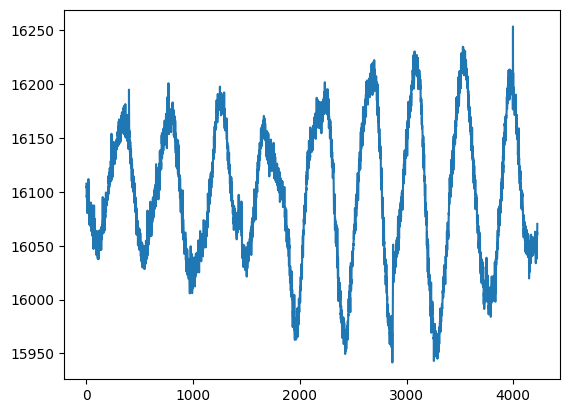

In [89]:
plt.plot(kepler22)

In [90]:
def fft_analysis(signal):
    
    # Linear detrending
    slope, intercept = np.polyfit(np.arange(len(signal)), signal, 1)
    trend = np.arange(len(signal)) * slope + intercept 
    detrended = signal - trend 
    
    fft_values = fft(detrended)
    frequencies = np.fft.fftfreq(len(fft_values))

    # Remove negative frequencies and sort
    positive_frequencies = frequencies[frequencies > 0]
    magnitudes = np.abs(fft_values)[frequencies > 0]

    # Identify dominant frequency
    dominant_frequency = positive_frequencies[np.argmax(magnitudes)]
    print(f"Dominant Frequency: {dominant_frequency:.3f}")

    # Convert frequency to period (e.g., days, weeks, months, etc.)
    dominant_period = 1 / dominant_frequency
    print(f"Dominant Period: {dominant_period:.2f} time units")
    
    return dominant_period, positive_frequencies, magnitudes

In [91]:
period, freqs, magnitudes = fft_analysis(star)

Dominant Frequency: 0.002
Dominant Period: 469.56 time units


In [92]:
ss_decomposition = seasonal_decompose(x=star, model='additive', period=470)
seq = np.arange(len(star))
est_trend = ss_decomposition.trend
est_seasonal = ss_decomposition.seasonal
est_noise = ss_decomposition.resid

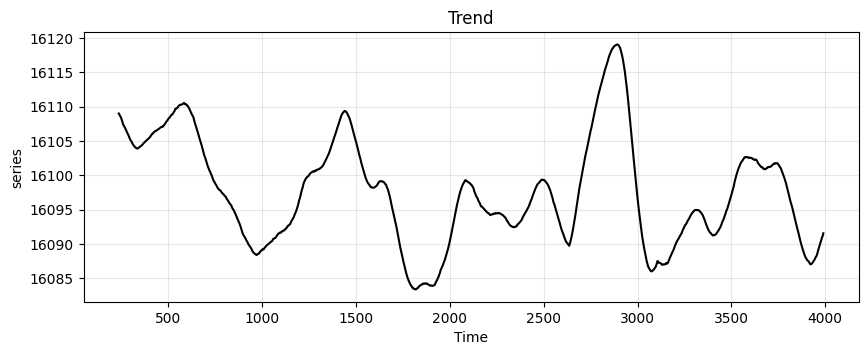

In [93]:
run_sequence_plot(seq, est_trend, title="Trend", ylabel="series");

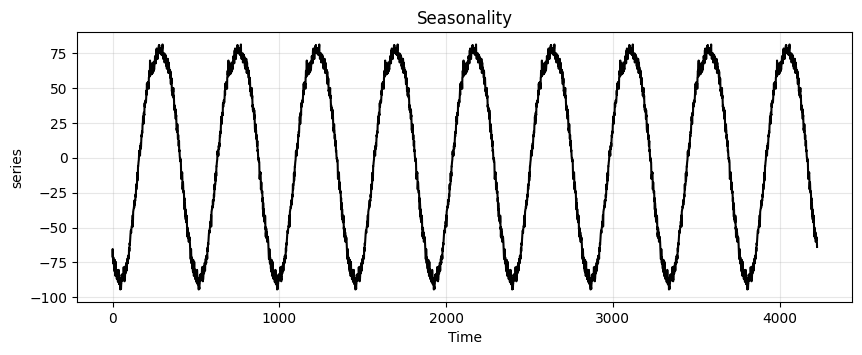

In [94]:
run_sequence_plot(seq, est_seasonal, title="Seasonality", ylabel="series");

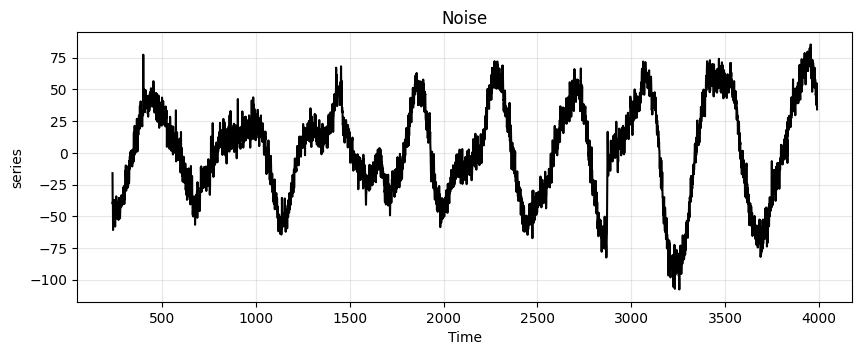

In [95]:
run_sequence_plot(seq, est_noise, title="Noise", ylabel="series");

#### Exercise 1

Comment on whether the remaining noise is White noise (stationary), or a Random Walk (non-stationary).

Verify your assumption via a ADF test on the `est_noise` component.

#### For some fun:

In [96]:
def fold(flux, period):
    flux = np.array(flux)
    time = np.arange(len(flux))  # treat indices as time
    phase = (time % period) / period
    sorted_indices = np.argsort(phase)
    
    return phase[sorted_indices], flux[sorted_indices]


In [97]:
phase, folded_flux = fold(star, 469.56)

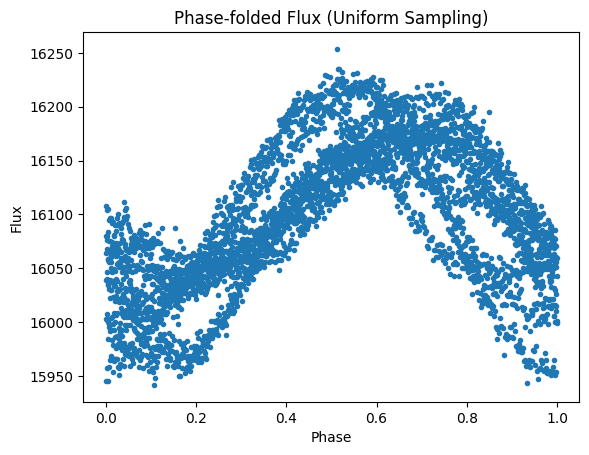

In [98]:
plt.plot(phase, folded_flux, '.')
plt.xlabel('Phase')
plt.ylabel('Flux')
plt.title('Phase-folded Flux (Uniform Sampling)')
plt.show()

Why is there a seasonal component underlying our star data?